# Unlocking Church Growth: Data Insights from the National Congregations Study
# Worship Service Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Worship Service of the congregation and how they may impact an attendance change. The features included are:<br>
 - Services: The number of services per week
 - Lenght: length of service in minutes
 - Sermon: was a sermon involved in the worship service?
 - Sermon Time: length of the sermon in minutes
 - Podium: did the speaker come down off the altar, podium, chancel, or stage during hte sermon?
 - Unique Speakers: how many unique speakers were there?
 - Greetings: Was time allocated for greetings, handshaking, etc. during the service?
 - Kids: was a part of the service specifically for children?
 - Teens: were any speaking, singing, or performing parts specifically for teens in the service?
 - Robe: did the clergy leader wear a robe?
 - Applause: was there applause during any point of the service?
 - Laughing: was laughing invoked during the service?
 - Bulletin: was a program, bulletin, or other written order of service distributed?
 - Streamed: was the service broadcast or streamed live?
 - Smartphone: were people offered the opportunity to use their smartphones to participate in some way?
 - Congregational Reading: did hte congregation speak, read, or recite something together at any point?
 - Offering: was a monetary offering collected during the service?
 - Social Time: how long did people mingle informally before and after the service in minutes?

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import itertools
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pointbiserialr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'SPKRDWN', 'NUMSPOKE', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING', 'SOCLTIME', 'change_category']
df_worship = data[selected_columns].copy()

In [7]:
# Drop DENOM
df_worship.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_worship.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_worship[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
df_worship_encoded = pd.concat([df_worship, encoded_df], axis=1)
df_worship_encoded = df_worship_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [8]:
# Basic exploration
df_worship.info()
df_worship.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NUMSERV1         5322 non-null   float64 
 1   LENGTH           5321 non-null   float64 
 2   SERMON           5326 non-null   object  
 3   SERMTIME         5289 non-null   float64 
 4   SPKRDWN          2777 non-null   object  
 5   NUMSPOKE         1215 non-null   float64 
 6   GREET            5326 non-null   object  
 7   KIDTIME          1232 non-null   object  
 8   TEENPART         1232 non-null   object  
 9   ROBE             4095 non-null   object  
 10  APPLAUSE         5320 non-null   object  
 11  LAUGH            1228 non-null   object  
 12  PROGRAM          5330 non-null   object  
 13  OVERHEAD         5326 non-null   object  
 14  STREAMED         1254 non-null   object  
 15  SMTPHONE         1255 non-null   object  
 16  CONGREAD         2737 non-null   object  


,NUMSERV1,LENGTH,SERMTIME,NUMSPOKE,SOCLTIME
count,5322.000000,5321.000000,5289.000000,1215.000000,4054.000000
mean,5.616967,81.415899,25.555493,3.688889,32.827578
std,28.010125,38.381398,20.816414,5.416309,26.042180
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,60.000000,15.000000,2.000000,15.000000
50%,3.000000,70.000000,20.000000,3.000000,30.000000
75%,7.000000,90.000000,35.000000,4.000000,40.000000
max,2000.000000,1440.000000,600.000000,125.000000,600.000000


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

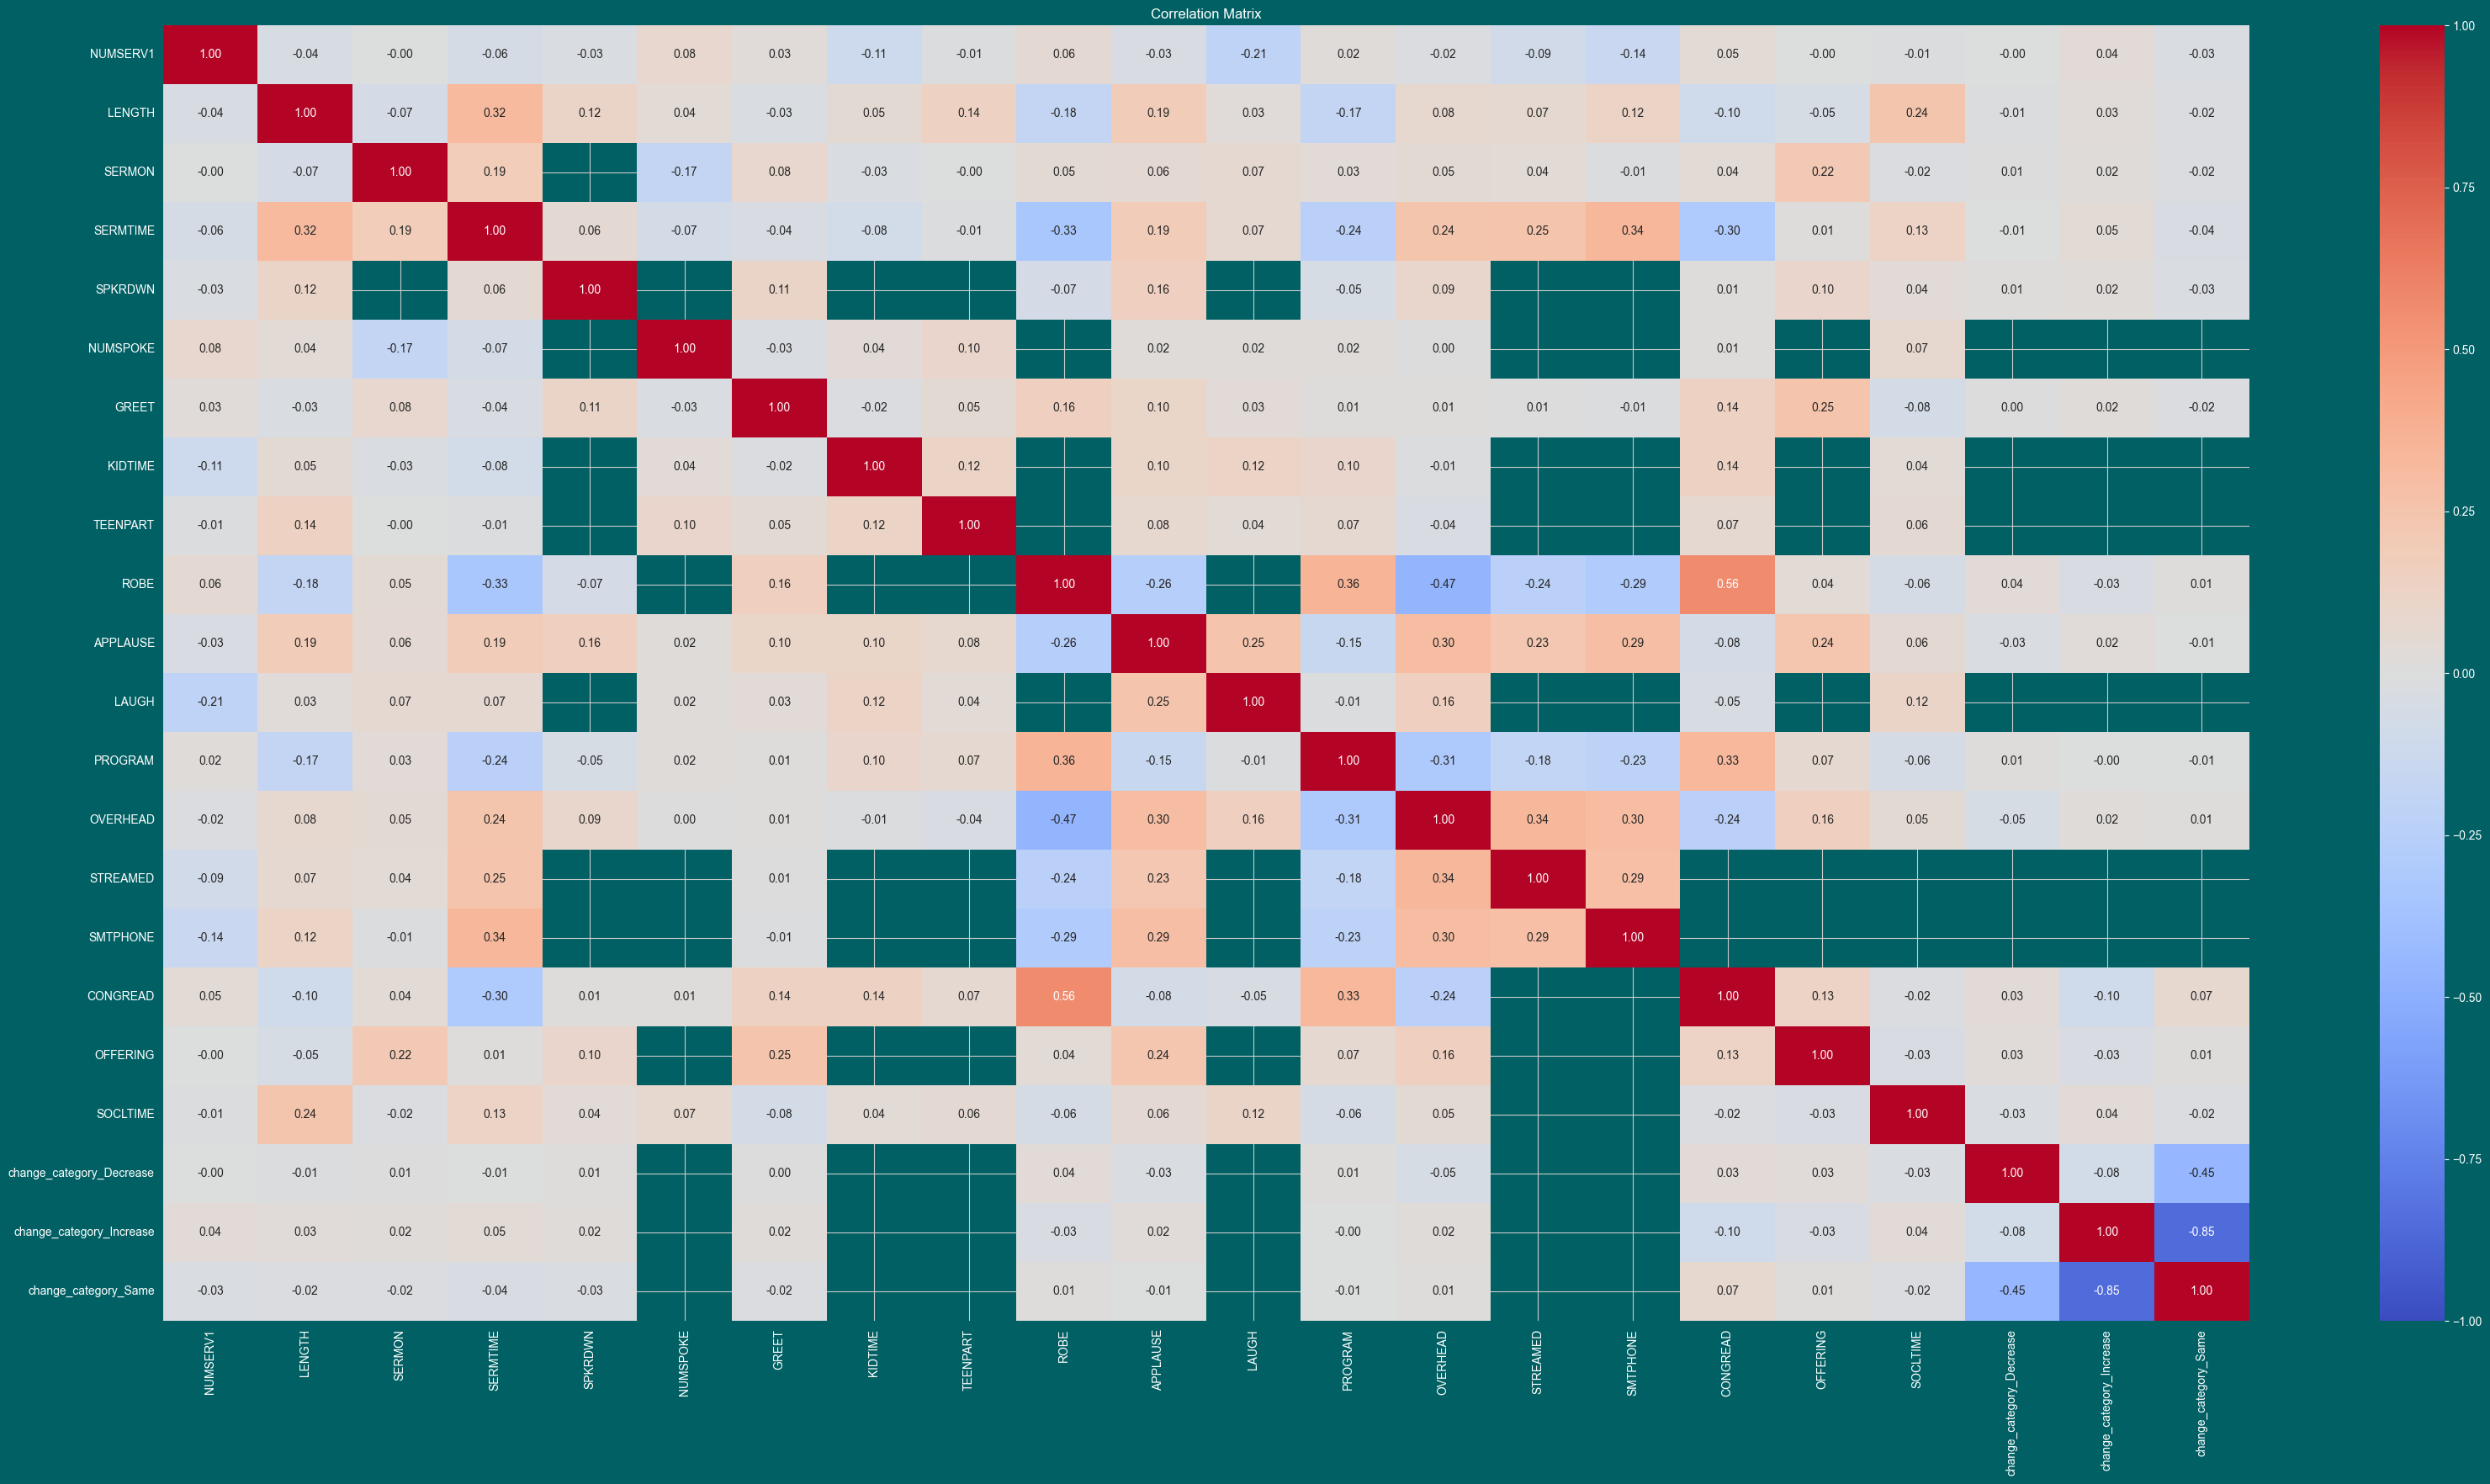

In [9]:
# Perform correlation analysis
correlation_matrix = df_worship_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

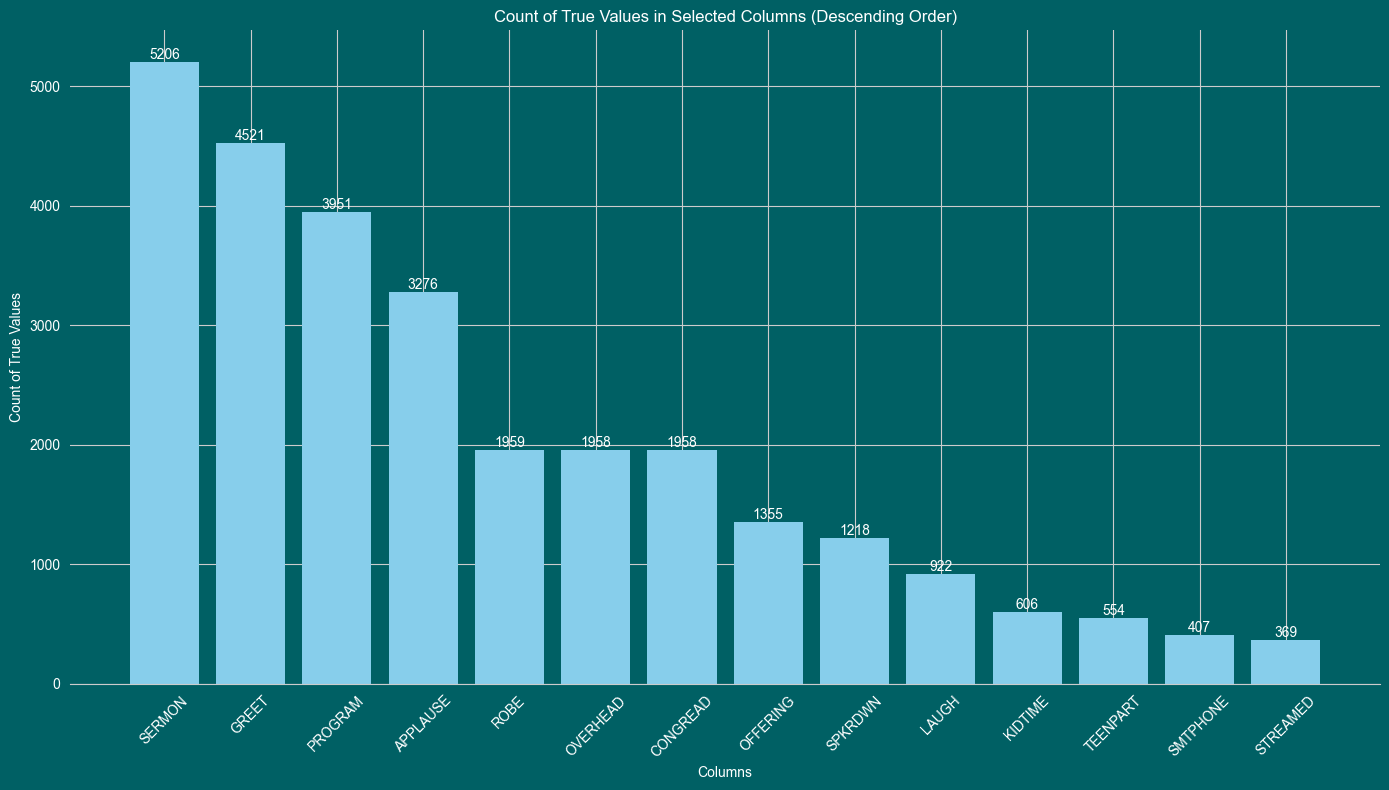

In [10]:
# Specify columns of interest
columns_of_interest = ['SERMON', 'SPKRDWN', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING']

# Count True values for each column
counts = {col: df_worship_encoded[col].sum() for col in columns_of_interest}

# Sort counts in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Plot counts for each column as multiple bars in one graph
plt.figure(figsize=(14, 8))

# Create the bar plot with sorted counts
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count of True Values')
plt.title('Count of True Values in Selected Columns (Descending Order)')

# Adding data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', 
             ha='center', va='bottom', fontsize=10)

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

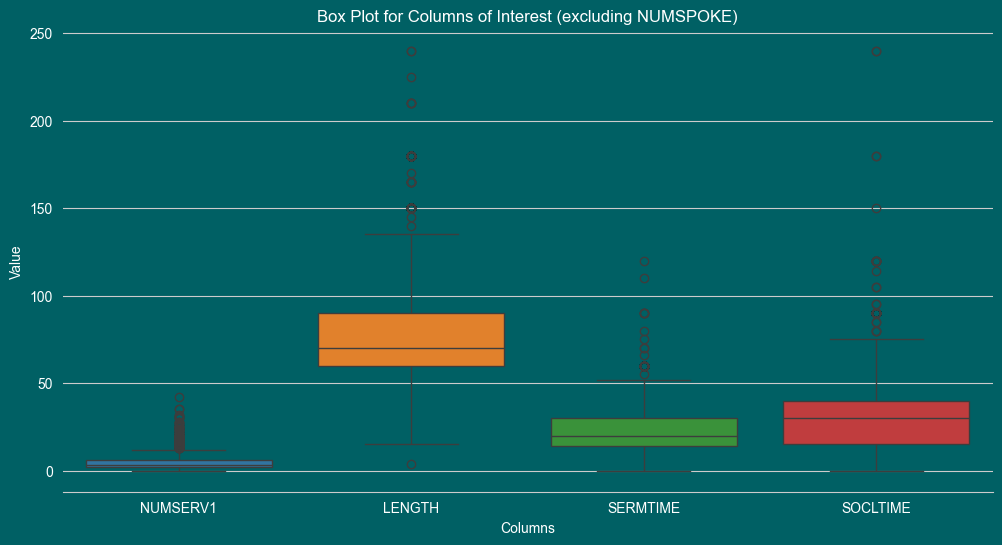

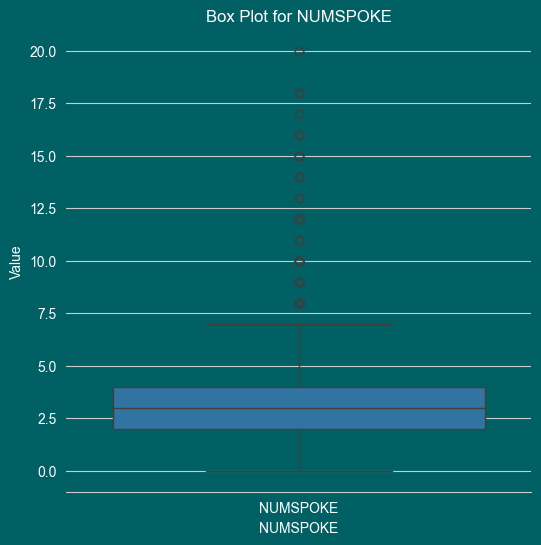

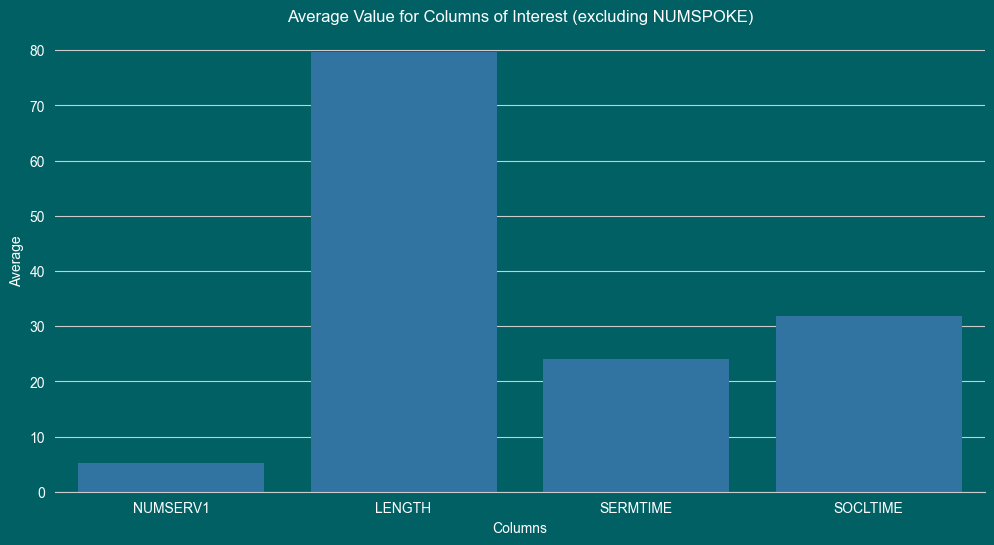

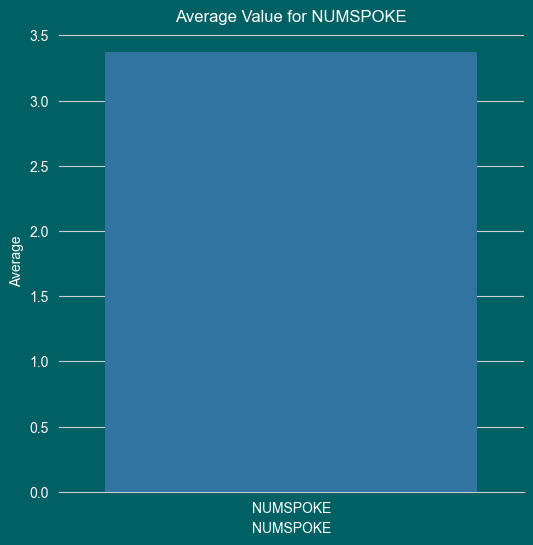

In [11]:
# Columns of interest
columns_of_interest = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'NUMSPOKE', 'SOCLTIME']

# Drop rows where any column of interest has a value greater than 250
df_filtered = df_worship_encoded[(df_worship_encoded[columns_of_interest] <= 250).all(axis=1)]

# Further drop rows where NUMSPOKE is greater than 20
df_filtered = df_filtered[df_filtered['NUMSPOKE'] <= 20]

# Calculate statistics for the filtered DataFrame
statistics_filtered = df_filtered[columns_of_interest].agg(['min', 'max', 'median', 'mean'])

# Separate NUMSPOKE
columns_without_numspoke = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'SOCLTIME']

# Box plot for columns without NUMSPOKE
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered[columns_without_numspoke])
plt.title('Box Plot for Columns of Interest (excluding NUMSPOKE)')
plt.ylabel('Value')
plt.xlabel('Columns')
plt.show()

# Box plot for NUMSPOKE
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_filtered[['NUMSPOKE']])
plt.title('Box Plot for NUMSPOKE')
plt.ylabel('Value')
plt.xlabel('NUMSPOKE')
plt.show()

# Bar plot for average without NUMSPOKE
plt.figure(figsize=(12, 6))
sns.barplot(x=columns_without_numspoke, y=statistics_filtered.loc['mean'][columns_without_numspoke])
plt.title('Average Value for Columns of Interest (excluding NUMSPOKE)')
plt.ylabel('Average')
plt.xlabel('Columns')
plt.show()

# Bar plot for average of NUMSPOKE
plt.figure(figsize=(6, 6))
sns.barplot(x=['NUMSPOKE'], y=[statistics_filtered.loc['mean']['NUMSPOKE']])
plt.title('Average Value for NUMSPOKE')
plt.ylabel('Average')
plt.xlabel('NUMSPOKE')
plt.show()

In [12]:
# Define columns of interest
columns_of_interest = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'NUMSPOKE', 'SOCLTIME']

# Filter the DataFrame to keep only the columns of interest
df_filtered = data[columns_of_interest]

# Export the filtered DataFrame to an Excel file
df_filtered.to_excel('worship_stats.xlsx', index=False)

In [13]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NUMSERV1  5322 non-null   float64
 1   LENGTH    5321 non-null   float64
 2   SERMTIME  5289 non-null   float64
 3   NUMSPOKE  1215 non-null   float64
 4   SOCLTIME  4054 non-null   float64
dtypes: float64(5)
memory usage: 208.4 KB


## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [14]:
# Chi-Square Test
# Perform Chi-squared test for each feature
results = {}
for column in df_worship.columns[:-1]:  # Exclude 'change_category'
    contingency_table = pd.crosstab(df_worship[column], df_worship['change_category'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results[column] = {'Chi2': chi2, 'p-value': p}

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

                Chi2   p-value
NUMSERV1  114.649901  0.040860
LENGTH    194.845984  0.010845
SERMON      2.447078  0.294187
SERMTIME  209.432307  0.000974
SPKRDWN     1.828054  0.400906
NUMSPOKE    0.000000  1.000000
GREET       1.486709  0.475516
KIDTIME     0.000000  1.000000
TEENPART    0.000000  1.000000
ROBE        9.167469  0.010217
APPLAUSE    5.971445  0.050503
LAUGH       0.000000  1.000000
PROGRAM     1.101587  0.576492
OVERHEAD   17.473542  0.000161
STREAMED    0.000000  1.000000
SMTPHONE    0.000000  1.000000
CONGREAD   26.692243  0.000002
OFFERING    1.793775  0.407837
SOCLTIME  216.729473  0.000013


In [15]:
# ANOVA Test
# Prepare results dictionary
results = {}

# Perform ANOVA for each feature
for column in df_worship.columns[:-1]:  # Exclude 'change_category'
    groups = [df_worship[df_worship['change_category'] == category][column] for category in df_worship['change_category'].unique()]
    f_stat, p_value = f_oneway(*groups)
    results[column] = {'F-statistic': f_stat, 'p-value': p_value}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
print(results_df)

          F-statistic  p-value
NUMSERV1          NaN      NaN
LENGTH            NaN      NaN
SERMON            NaN      NaN
SERMTIME          NaN      NaN
SPKRDWN           NaN      NaN
NUMSPOKE          NaN      NaN
GREET             NaN      NaN
KIDTIME           NaN      NaN
TEENPART          NaN      NaN
ROBE              NaN      NaN
APPLAUSE          NaN      NaN
LAUGH             NaN      NaN
PROGRAM           NaN      NaN
OVERHEAD          NaN      NaN
STREAMED          NaN      NaN
SMTPHONE          NaN      NaN
CONGREAD          NaN      NaN
OFFERING          NaN      NaN
SOCLTIME          NaN      NaN


## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

Accuracy of the Random Forest model: 0.7021


<Figure size 2000x1200 with 0 Axes>

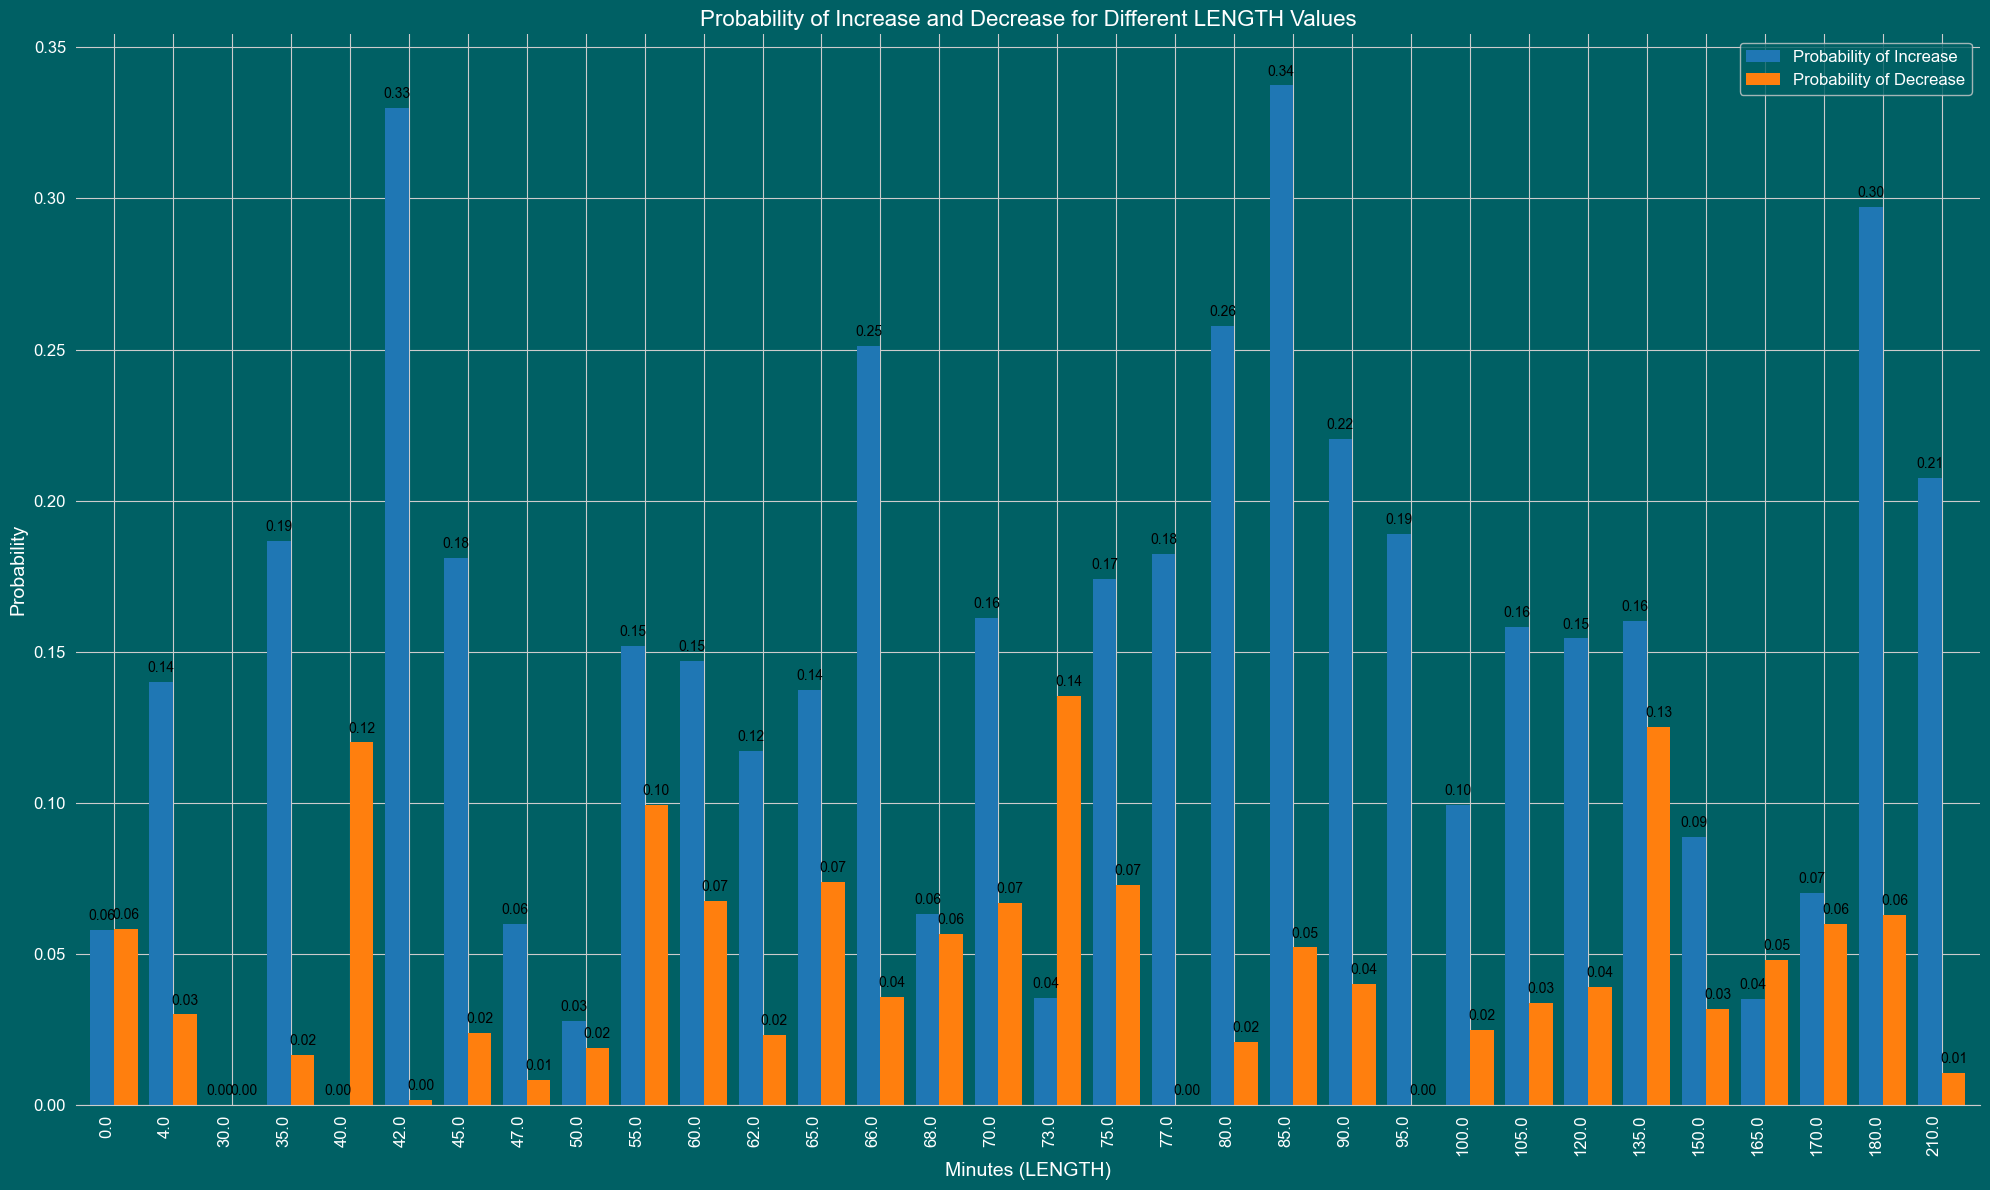

<Figure size 2000x1200 with 0 Axes>

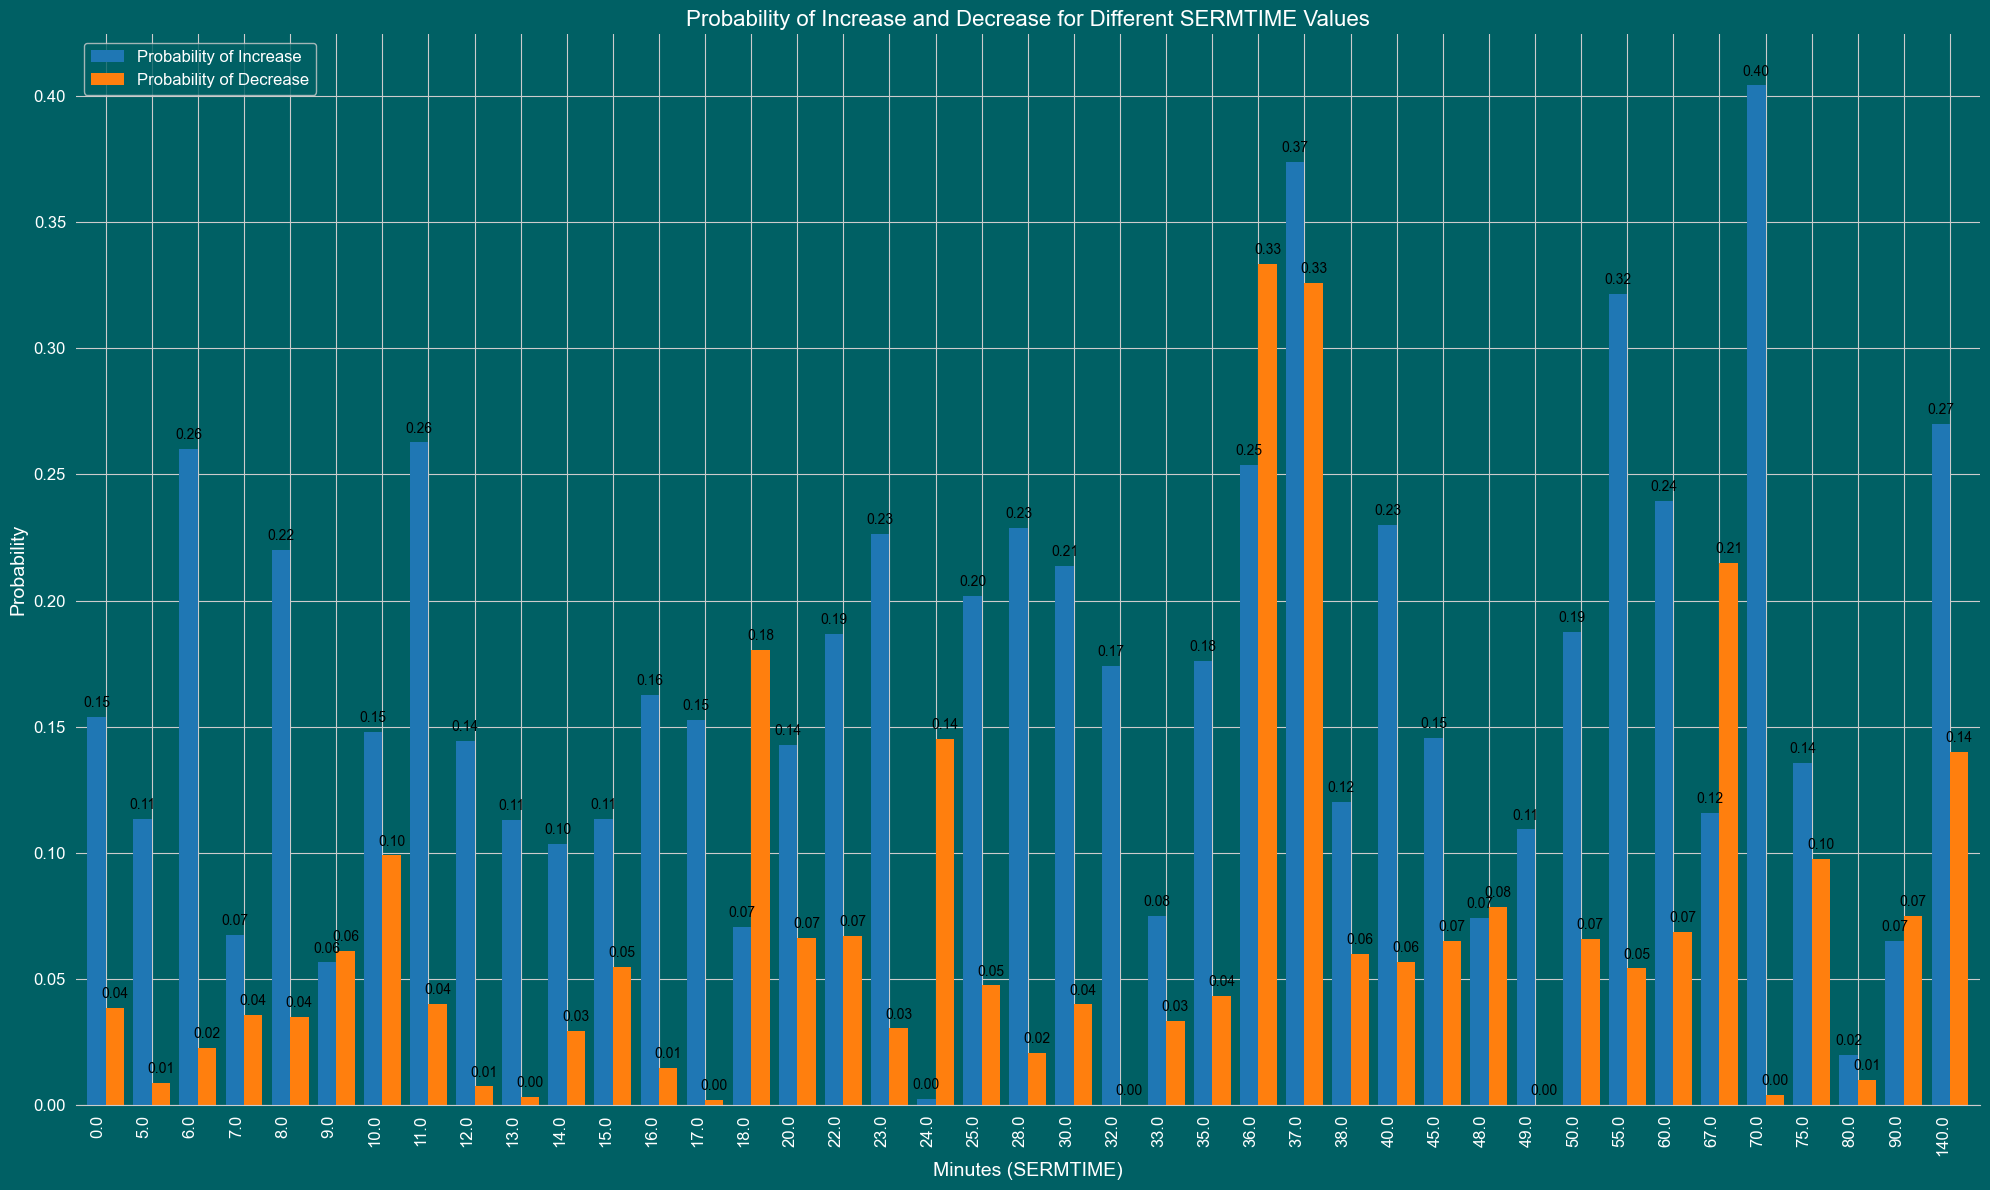

<Figure size 2000x1200 with 0 Axes>

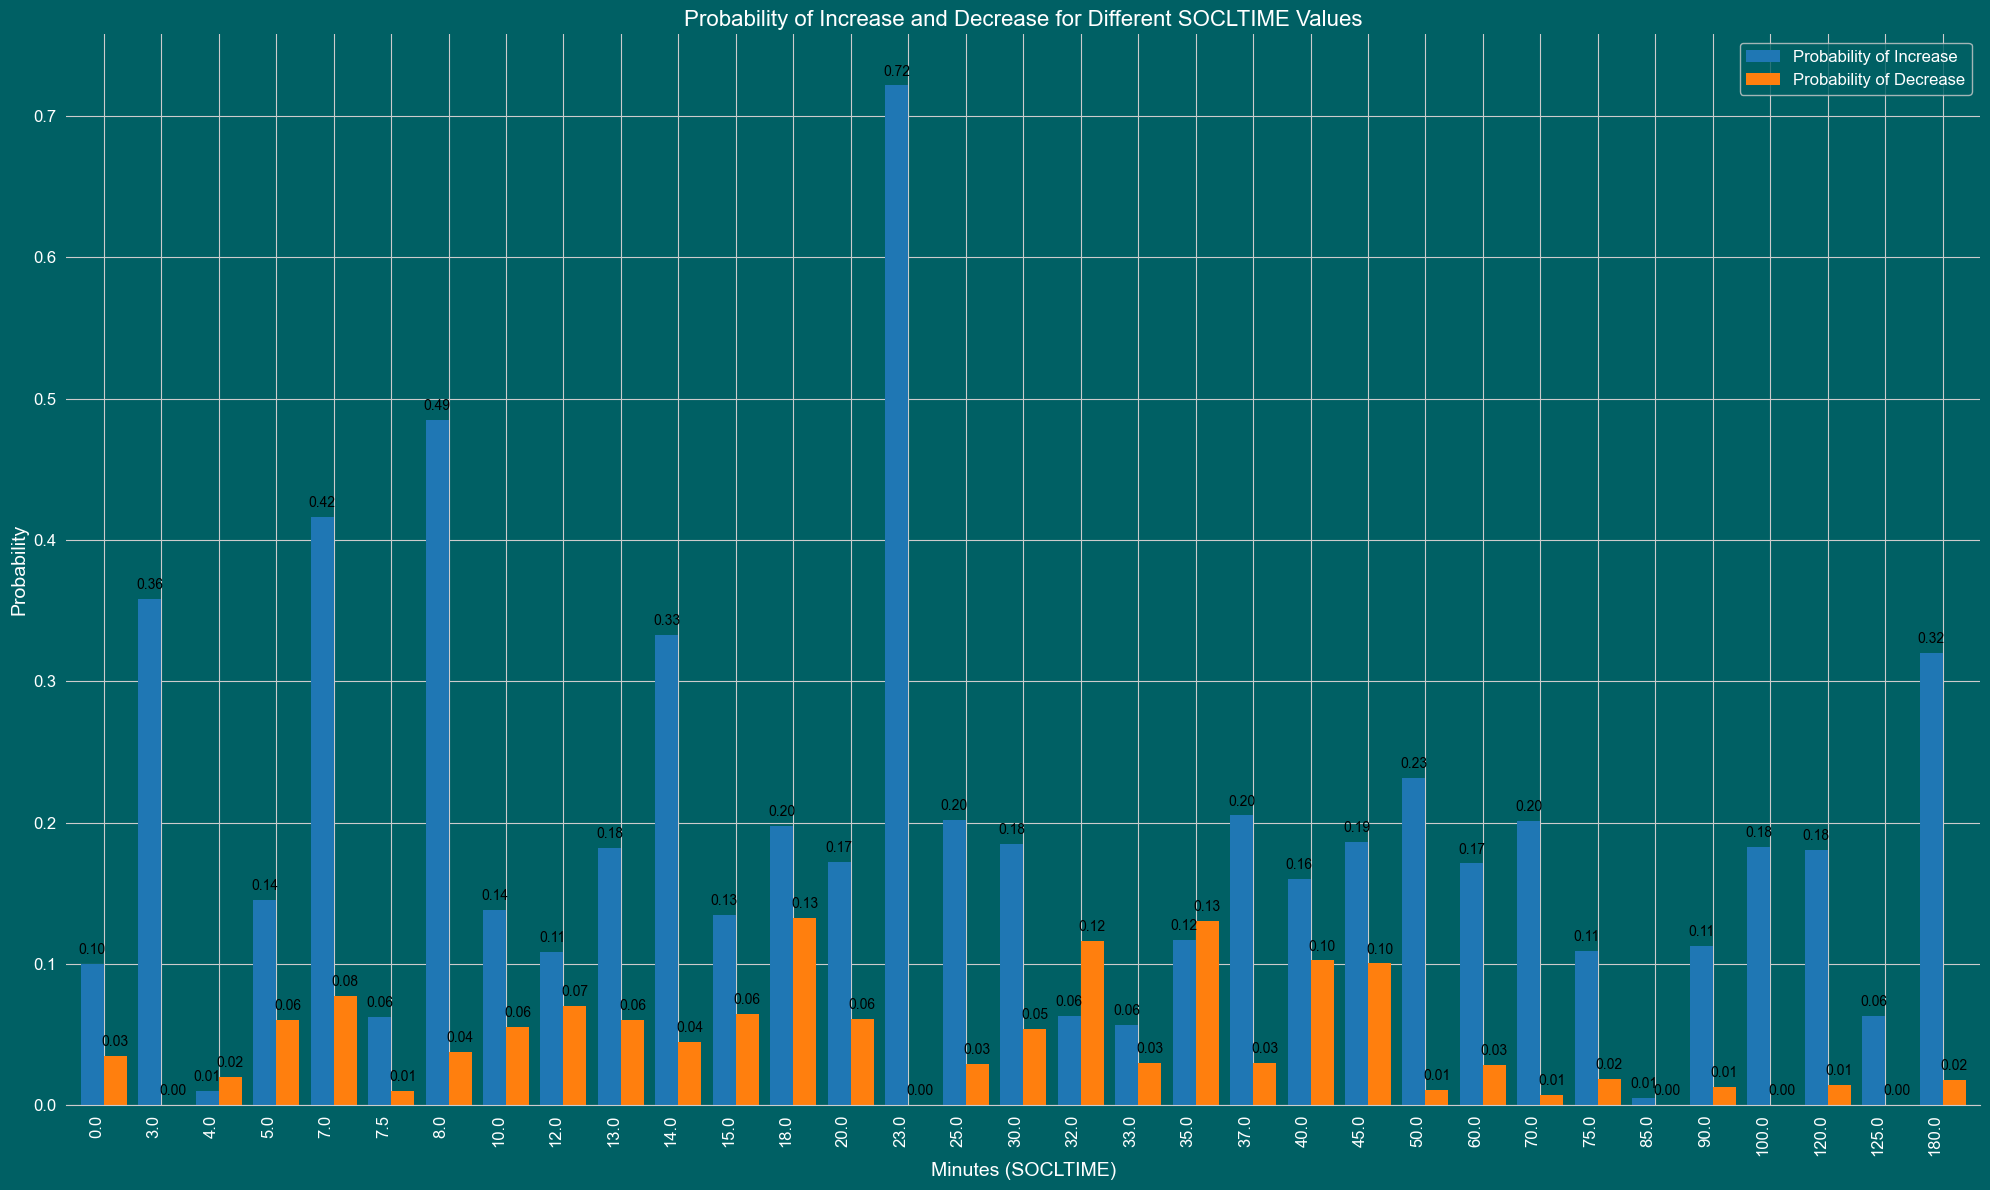

In [25]:
# Random Forest 1

# Select specific features
selected_columns = ['LENGTH', 'SERMTIME', 'SOCLTIME', 'change_category']
df_worship = data[selected_columns].copy()

# Drop rows where values in the three features are greater than 250
df_worship_rf1 = df_worship[(df_worship['LENGTH'] <= 250) & (df_worship['SERMTIME'] <= 250) & (df_worship['SOCLTIME'] <= 250)].copy()

# Encode categorical variables
le = LabelEncoder()
df_worship_rf1['change_category'] = le.fit_transform(df_worship_rf1['change_category'])

# Split the data into training and test sets
X = df_worship_rf1[['LENGTH', 'SERMTIME', 'SOCLTIME']]
y = df_worship_rf1['change_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities on the test set
y_prob = rf.predict_proba(X_test)

# Function to calculate and plot probabilities for a given feature
def plot_probabilities(feature):
    df = X_test.copy()
    df['prob_increase'] = y_prob[:, le.transform(['Increase'])[0]]
    df['prob_decrease'] = y_prob[:, le.transform(['Decrease'])[0]]

    df_grouped = df.groupby(feature).mean()[['prob_increase', 'prob_decrease']].sort_index()

    # Plot the probabilities
    plt.figure(figsize=(20, 12))  # Adjust figure size for better visibility
    ax = df_grouped.plot(kind='bar', width=0.8, figsize=(20, 12))
    plt.xlabel(f'Minutes ({feature})', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    plt.title(f'Probability of Increase and Decrease for Different {feature} Values', fontsize=16)
    plt.xticks(rotation=90, ha='right', fontsize=12)  # Rotate x-axis labels
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.legend(['Probability of Increase', 'Probability of Decrease'], fontsize=12)

    # Add data labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
                    textcoords='offset points')

    plt.show()

# Plot for LENGTH
plot_probabilities('LENGTH')

# Plot for SERMTIME
plot_probabilities('SERMTIME')

# Plot for SOCLTIME
plot_probabilities('SOCLTIME')

C:\Users\natha\AppData\Local\Temp\ipykernel_9588\858213569.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_worship_rf2[col] = df_worship_rf2[col].fillna(False)


Accuracy of the Random Forest model: 0.8400


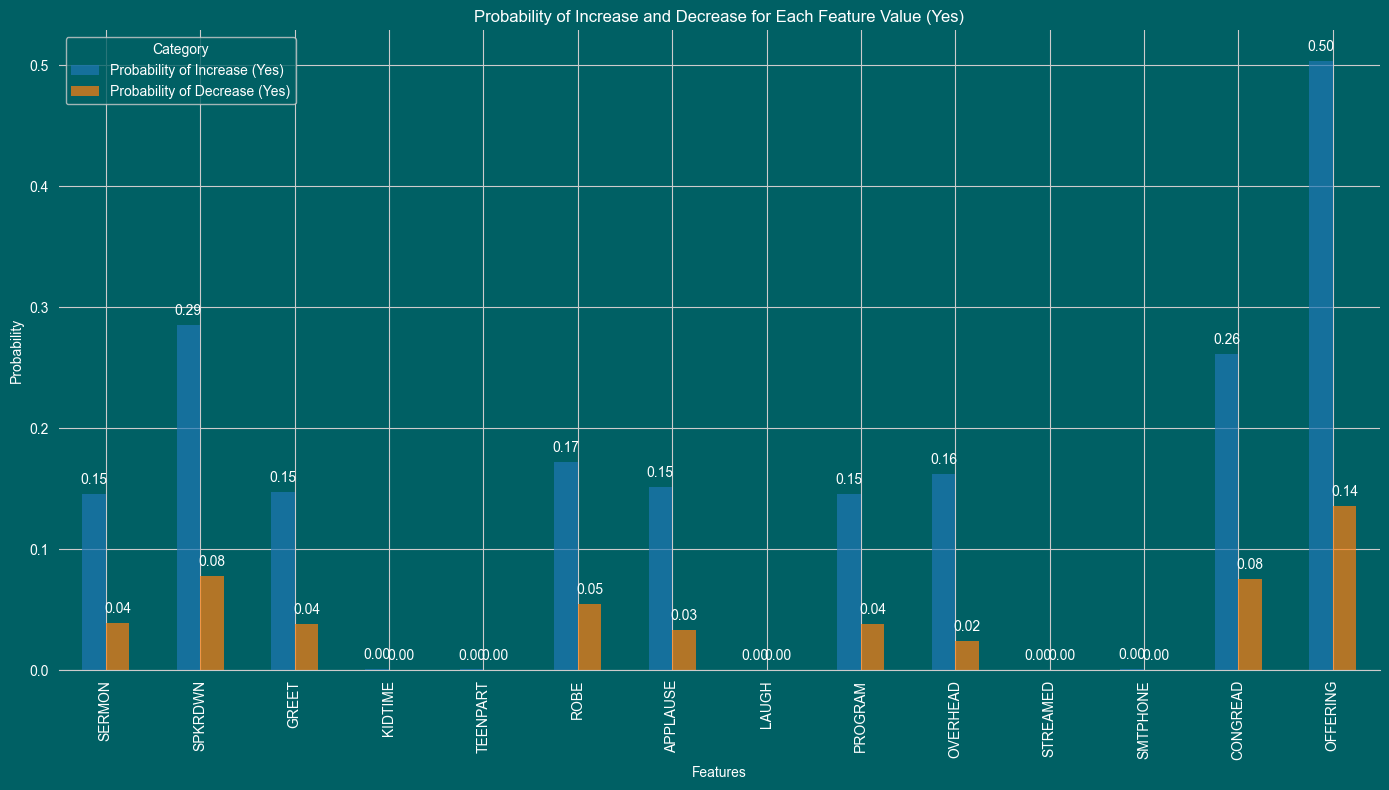

In [20]:
# Random Forest 2

# Select specific features
selected_columns = ['SERMON', 'SPKRDWN', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING', 'change_category']
df_worship_rf2 = data[selected_columns].copy()

# Replace NaN or missing values with False, except for the categorical column 'change_category'
for col in df_worship_rf2.columns:
    if col != 'change_category':  # Exclude the categorical column
        df_worship_rf2[col] = df_worship_rf2[col].fillna(False)

# Prepare features and target
X = df_worship_rf2.drop('change_category', axis=1)
y = df_worship_rf2['change_category']

# Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Keep y aligned with X after dropping rows

# Convert Boolean features to int
X = X.astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities
probs = rf_model.predict_proba(X_test)

# Convert probabilities to DataFrame
probs_df = pd.DataFrame(probs, columns=rf_model.classes_, index=X_test.index)

# Calculate mean probabilities for 'yes' for 'Increase' and 'Decrease'
feature_probs = {}

for feature in X.columns:
    feature_probs[feature] = {
        'Increase': probs_df.loc[X_test[feature] == 1, 'Increase'].mean(),
        'Decrease': probs_df.loc[X_test[feature] == 1, 'Decrease'].mean()
    }

# Convert to DataFrame for plotting
feature_probs_df = pd.DataFrame(feature_probs).T
feature_probs_df.columns = ['Probability of Increase (Yes)', 'Probability of Decrease (Yes)']

# Plot
ax = feature_probs_df.plot(kind='bar', figsize=(14, 8), alpha=0.7)
plt.title('Probability of Increase and Decrease for Each Feature Value (Yes)')
plt.xlabel('Features')
plt.ylabel('Probability')
plt.legend(title='Category')
plt.tight_layout()

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Accuracy of the Random Forest model: 0.8231


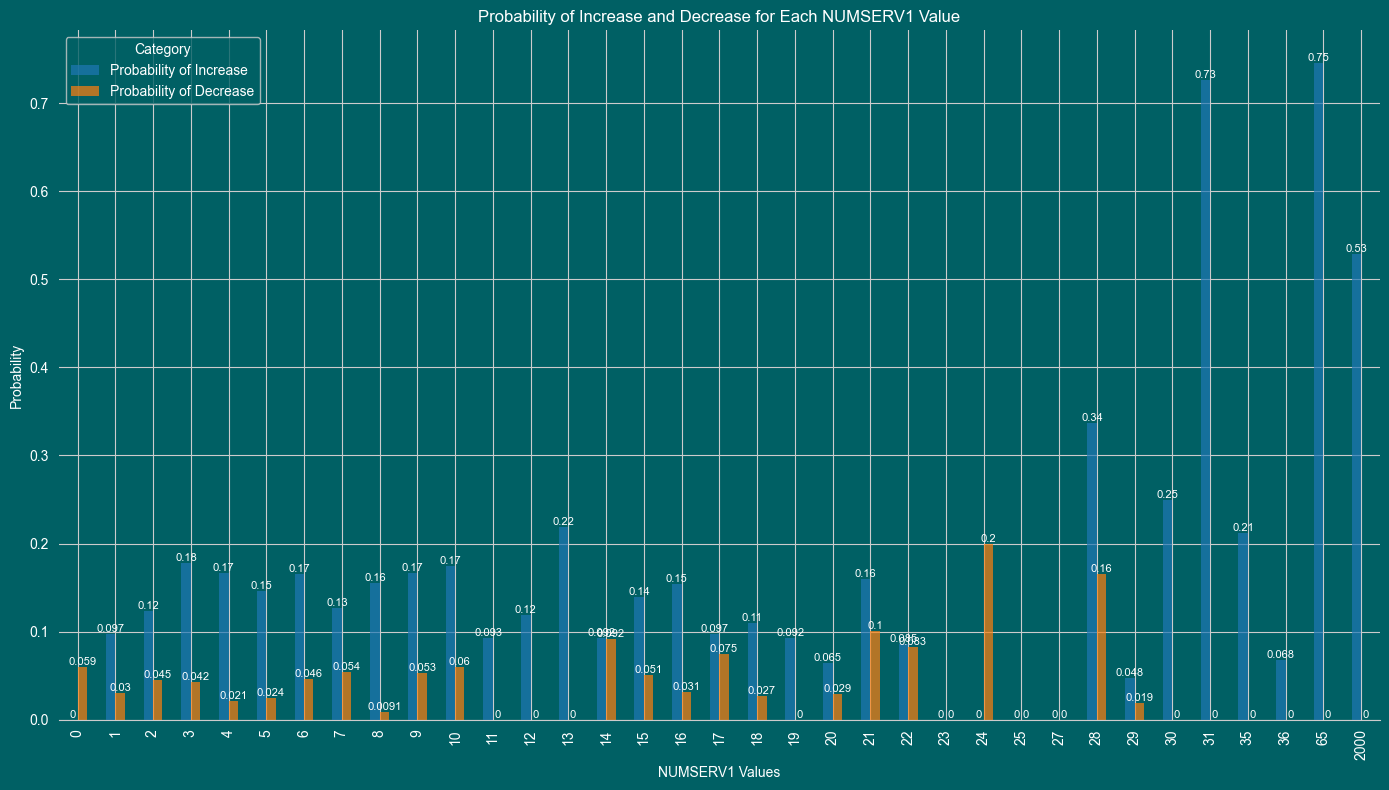

In [37]:
# Random Forest 3

# Select specific features
selected_columns = ['NUMSERV1', 'change_category']
df_worship_rf3 = data[selected_columns].copy()


# Replace NaN or missing values with False, except for the categorical column 'change_category'
for col in df_worship_rf3.columns:
    if col != 'change_category':  # Exclude the categorical column
        df_worship_rf3[col] = df_worship_rf3[col].fillna(False)

# Prepare features and target
X = df_worship_rf3.drop('change_category', axis=1)
y = df_worship_rf3['change_category']

# Convert Boolean features to int
X = X.astype(int)

# Drop rows with missing values (if any)
X = X.dropna()
y = y[X.index]  # Keep y aligned with X after dropping rows

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities
probs = rf_model.predict_proba(X_test)

# Convert probabilities to DataFrame
probs_df = pd.DataFrame(probs, columns=rf_model.classes_, index=X_test.index)

# Calculate mean probabilities for each unique value of NUMSERV1
unique_values = X_test['NUMSERV1'].unique()
value_probs = {
    'NUMSERV1': [],
    'Probability of Increase': [],
    'Probability of Decrease': []
}

for value in unique_values:
    increase_prob = probs_df.loc[X_test['NUMSERV1'] == value, 'Increase'].mean()
    decrease_prob = probs_df.loc[X_test['NUMSERV1'] == value, 'Decrease'].mean()
    
    value_probs['NUMSERV1'].append(value)
    value_probs['Probability of Increase'].append(increase_prob)
    value_probs['Probability of Decrease'].append(decrease_prob)

# Convert to DataFrame for plotting and sort by 'NUMSERV1'
value_probs_df = pd.DataFrame(value_probs).sort_values(by='NUMSERV1')

# Plotting
ax = value_probs_df.set_index('NUMSERV1').plot(kind='bar', figsize=(14, 8), alpha=0.7)

# Adding data labels with smaller text and two significant figures
for container in ax.containers:
    labels = [f'{v:.2g}' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=8)

plt.title('Probability of Increase and Decrease for Each NUMSERV1 Value')
plt.xlabel('NUMSERV1 Values')
plt.ylabel('Probability')
plt.legend(title='Category')
plt.tight_layout()

# Show the plot
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.